In [2]:
import healpy as hp
import healsparse as hsp
import skyproj
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import glob
import os,sys
import fitsio as fio
from tqdm import tqdm
import proplot as pplt
import pickle
import glob
from astropy.io import fits
from scipy.optimize import curve_fit
import healsparse
import healpy as hp
import pandas as pd
from math import log10
import healsparse as hsp
import skyproj
from des_y6utils import mdet
import h5py as h5

%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [4]:
f = h5.File('/global/cfs/cdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V5b/metadetect_desdmv5a_cutsv5_patchesv5b.h5', 'r')
d_y6 = f.get('/mdet/noshear')
ra = np.array(d_y6['ra']); dec = np.array(d_y6['dec'])
fluxerr_g = np.array(d_y6['pgauss_band_flux_err_g'])
fluxerr_r = np.array(d_y6['pgauss_band_flux_err_r'])
fluxerr_i = np.array(d_y6['pgauss_band_flux_err_i'])
fluxerr_z = np.array(d_y6['pgauss_band_flux_err_z'])

In [6]:
nside_coverage = 512
nside_sparse = 4096

desy6_map_fluxerr = np.zeros(hp.nside2npix(nside_sparse))
desy6_map_count = np.zeros(hp.nside2npix(nside_sparse))
pix = hp.ang2pix(nside_sparse, ra, dec, lonlat=True, nest=True)

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
desy6_map_fluxerr[unique_pix] += np.bincount(idx_rep, weights=fluxerr_g)
desy6_map_count[unique_pix] += np.bincount(idx_rep, weights=np.ones(len(pix)))

res_fluxerr = np.log10(desy6_map_fluxerr/desy6_map_count)
hsp_map_fluxerr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=res_fluxerr)

<ipython-input-6-18af41e96b88>:12: RuntimeWarning: invalid value encountered in true_divide
  res_fluxerr = np.log10(desy6_map_fluxerr/desy6_map_count)


<ipython-input-7-dcc8450cdcfb>:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


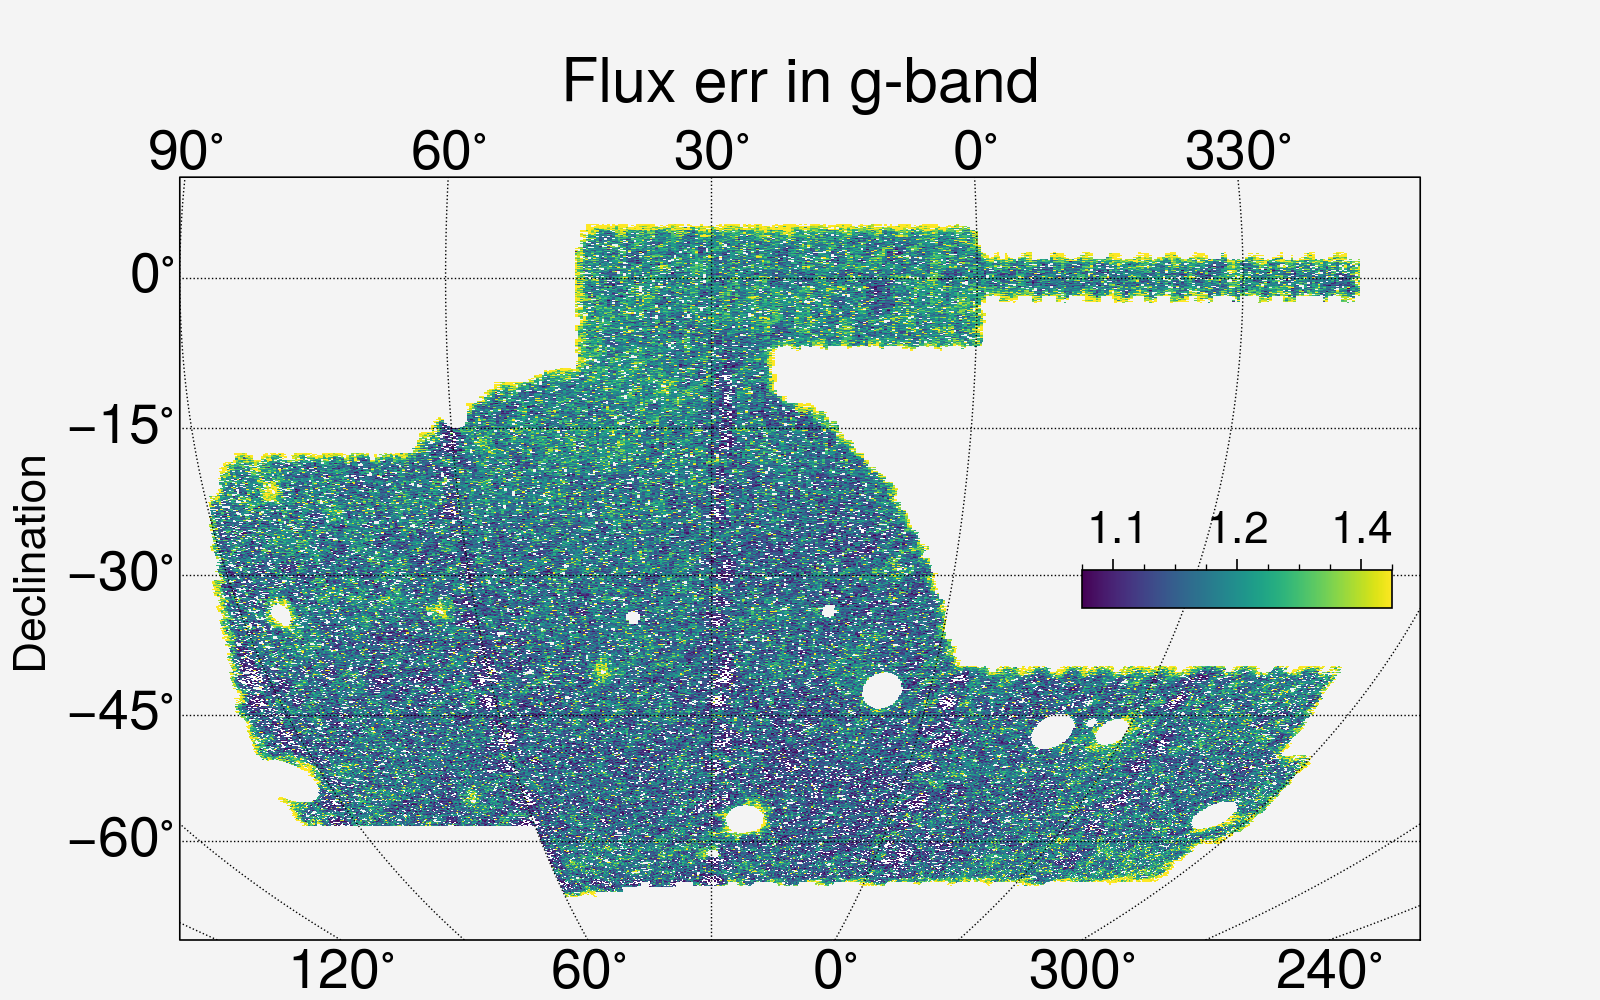

In [7]:
fig,ax = plt.subplots(figsize=(8,5))
my_cmap = matplotlib.cm.get_cmap('viridis')
my_cmap.set_under('white')
m = skyproj.DESSkyproj(ax=ax)
m.draw_des(label='DES', edgecolor='none',)
_ = m.draw_hspmap(hsp_map_fluxerr, cmap=my_cmap, zoom=False)
m.draw_inset_colorbar(fontsize=16)
plt.title('Flux err in g-band', y=1.08)
plt.tight_layout()
# plt.savefig('/global/homes/m/myamamot/DES/des-y6-analysis/vf_figures/final_paper/spatial_dist_s2n.pdf', bbox_inches='tight', dpi=100)

In [10]:
# Just to check size ratio
d = fio.read('/global/cfs/cdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V5b/jackknife_patches_blinded/patch-0000.fits')
print(d.dtype)
pgauss_T_ratio = d['pgauss_T']/d['pgauss_psf_T']

[('uid', '>i8'), ('patch_num', '>i2'), ('tilename', '<U12'), ('slice_id', '>i2'), ('mdet_step', '<U7'), ('ra', '>f8'), ('dec', '>f8'), ('x', '>f4'), ('y', '>f4'), ('mfrac', '>f4'), ('mfrac_img', '>f4'), ('nepoch_g', '>i4'), ('nepoch_r', '>i4'), ('nepoch_i', '>i4'), ('nepoch_z', '>i4'), ('psfrec_g_1', '>f8'), ('psfrec_g_2', '>f8'), ('psfrec_T', '>f4'), ('gauss_s2n', '>f4'), ('gauss_g_1', '>f8'), ('gauss_g_2', '>f8'), ('gauss_g_cov_1_1', '>f4'), ('gauss_g_cov_1_2', '>f4'), ('gauss_g_cov_2_2', '>f4'), ('gauss_T_err', '>f4'), ('gauss_T_ratio', '>f4'), ('gauss_psf_T', '>f4'), ('pgauss_T_err', '>f4'), ('pgauss_T', '>f4'), ('pgauss_psf_T', '>f4'), ('pgauss_band_flux_g', '>f4'), ('pgauss_band_flux_r', '>f4'), ('pgauss_band_flux_i', '>f4'), ('pgauss_band_flux_z', '>f4'), ('pgauss_band_flux_err_g', '>f4'), ('pgauss_band_flux_err_r', '>f4'), ('pgauss_band_flux_err_i', '>f4'), ('pgauss_band_flux_err_z', '>f4')]


/global/homes/m/myamamot/miniforge3/envs/eastlake-dev/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/global/homes/m/myamamot/miniforge3/envs/eastlake-dev/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


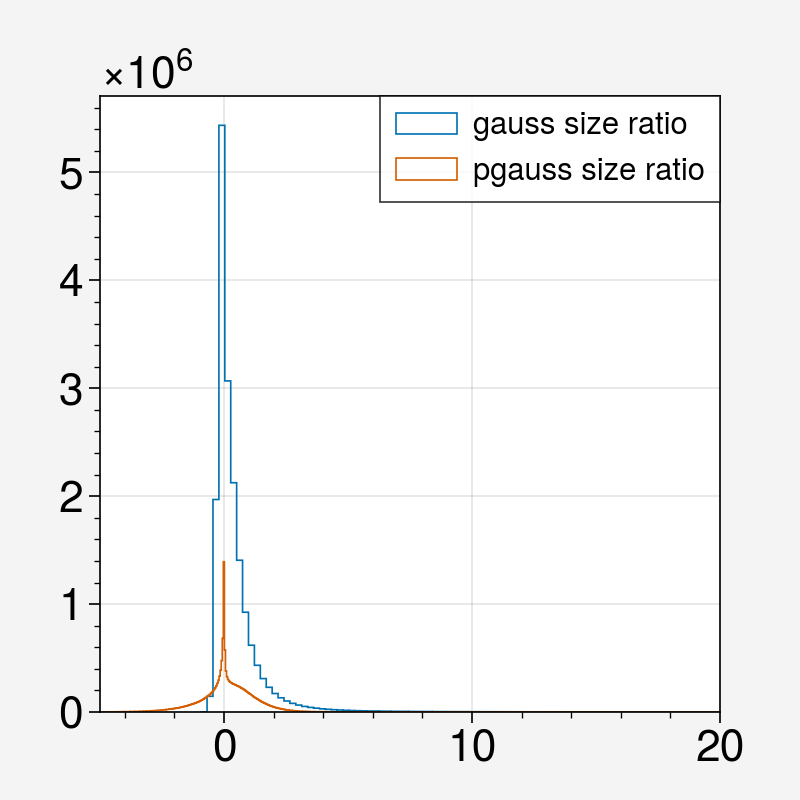

In [15]:
matplotlib.rcParams.update({'font.size': 16, 'legend.fontsize':'x-small'})
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax.hist(d['gauss_T_ratio'], bins=10000000, histtype='step', label='gauss size ratio')
ax.hist(pgauss_T_ratio, bins=100000, histtype='step', label='pgauss size ratio')
ax.set_xlim(-5,20)
ax.legend()

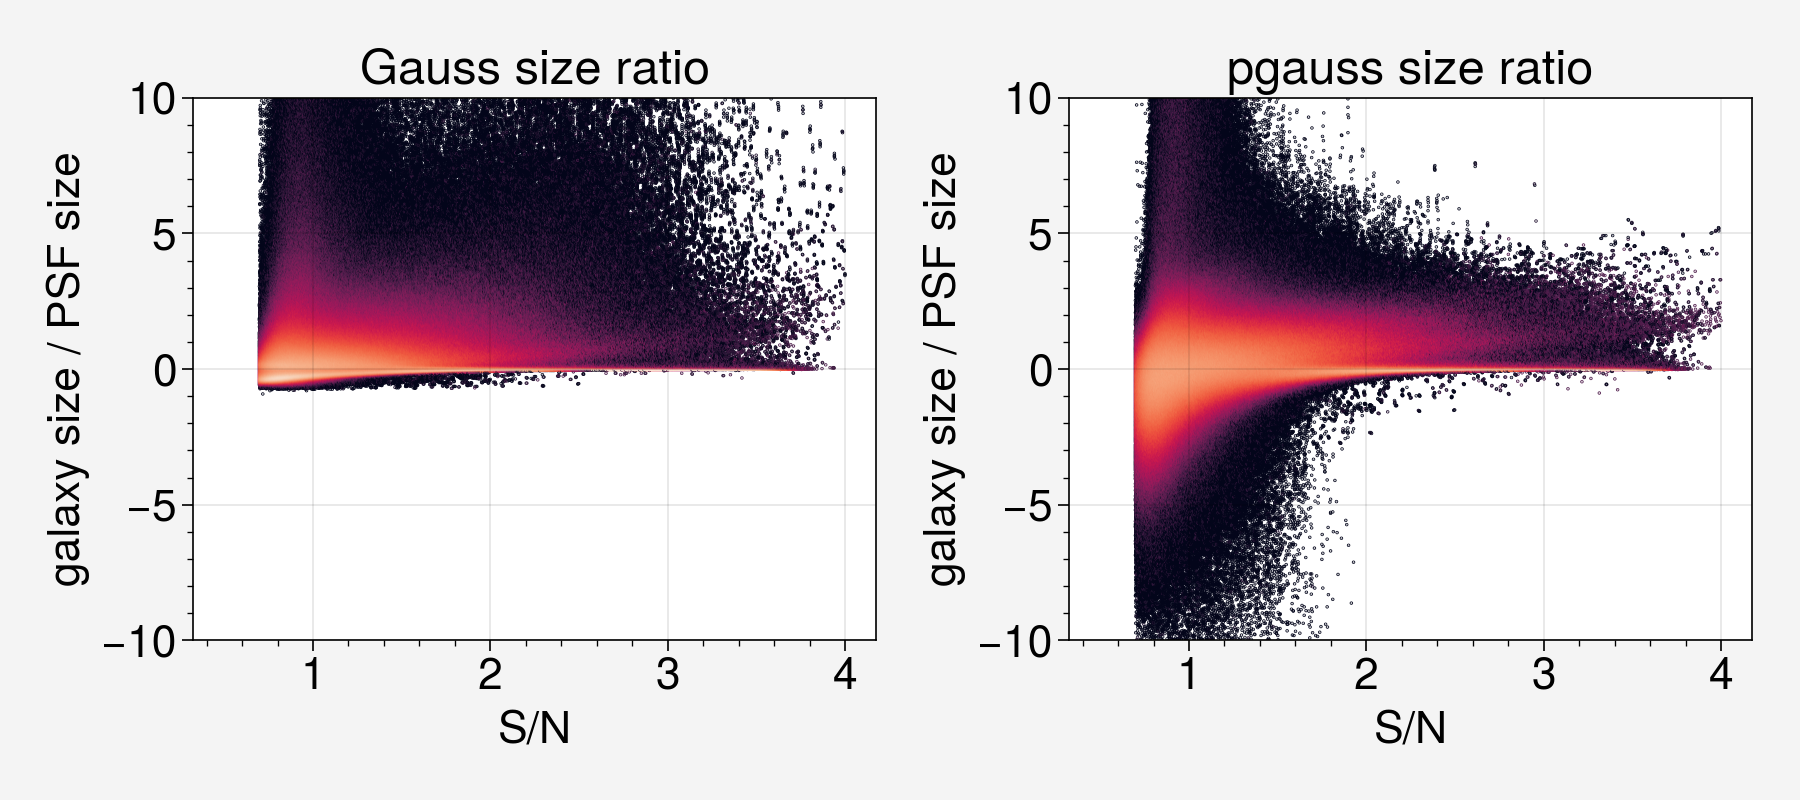

In [19]:
matplotlib.rcParams.update({'font.size': 16, 'legend.fontsize':'x-small'})
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharex=False, sharey=False)
ax[0].hexbin(np.log10(d['gauss_s2n']), d['gauss_T_ratio'], bins='log', cmap='rocket', gridsize=1000, mincnt=0.00001, extent=(0.5, 4, -10, 10))
ax[0].set_ylim(-10, 10)
ax[0].set_xlabel('S/N')
ax[0].set_ylabel('galaxy size / PSF size')
ax[0].set_title('Gauss size ratio')

ax[1].hexbin(np.log10(d['gauss_s2n']), pgauss_T_ratio, bins='log', cmap='rocket', gridsize=1000, mincnt=0.00001, extent=(0.5, 4, -10, 10))
ax[1].set_ylim(-10, 10)
ax[1].set_xlabel('S/N')
ax[1].set_ylabel('galaxy size / PSF size')
ax[1].set_title('pgauss size ratio')

plt.tight_layout()